In [1]:
import os
import sys
import pandas as pd
import geopandas as gpd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    precision_recall_curve,
    ConfusionMatrixDisplay,
    roc_curve,
    RocCurveDisplay,
    auc,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

sys.path.append("../utils")



In [2]:
data = pd.read_csv("/capstone/wildfire_prep/data/PUZZLE_PIECES/assembled_puzzle.csv")

In [3]:
data.columns

Index(['inspection_id', 'X_0', 'X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7',
       'X_8',
       ...
       'X_3995', 'X_3996', 'X_3997', 'X_3998', 'X_3999', 'basemap_id',
       'maj_landcover_code_x', 'maj_landcover_code_y', 'status',
       'structure_code'],
      dtype='object', length=4006)

In [4]:
# drop basemap_id 

data = data.drop(columns = 'basemap_id')

In [5]:
print(data.shape)
data.head()

(67580, 4005)


,inspection_id,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_3994,X_3995,X_3996,X_3997,X_3998,X_3999,maj_landcover_code_x,maj_landcover_code_y,status,structure_code
0,1,0.054892,0.0,0.015004,0.0,0.238797,0.000466,0.0,0.055266,0.005605,...,0.052267,2.742807,1.274291,1.905394,4.261047,2.500061,304.0,557,0,100
1,2,0.024470,0.0,0.003108,0.0,0.129467,0.000687,0.0,0.034108,0.012225,...,0.232065,2.272318,1.205103,1.661454,3.457836,2.098205,304.0,304,0,101
2,3,0.271383,0.0,0.126712,0.0,0.976787,0.043854,0.0,0.528058,0.124882,...,0.000000,3.815154,1.246298,2.504779,6.486201,3.454411,303.0,303,0,101
3,4,0.097084,0.0,0.037654,0.0,0.549639,0.001046,0.0,0.240636,0.017580,...,0.016924,3.105121,1.228030,2.112541,5.209030,2.868551,39.0,304,0,100
4,5,0.041986,0.0,0.008531,0.0,0.253195,0.001353,0.0,0.036694,0.002605,...,0.040597,2.683573,1.311833,1.853227,4.251881,2.500635,304.0,304,0,101


## Downsample Majority Class Approach

In [8]:

# Pull out majority/minority from data
compliant = data[data.status == 0]
non_compliant = data[data.status == 1]

# Downsample majority to be 3x minority's size
n_majority_desired = len(non_compliant) * 3
compliant_down = compliant.sample(n=n_majority_desired, random_state=42)

# Reassemble and shuffle
data_downsampled_maj = (
    pd.concat([non_compliant, compliant_down])
    .sample(frac=1, random_state=42)
    .reset_index(drop=True))

# Split back into X_train and y_train, downsampled
X = data_downsampled_maj.drop("status", axis=1)
y = data_downsampled_maj["status"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Balance check
print("Shapes:")
print("  X_train:", X_train.shape)
print("  y_train:", y_train.shape)
print("  X_test: ", X_test.shape)
print("  y_test: ", y_test.shape)

print("\nTrain distribution after downsampling:")
print(y_train.value_counts(normalize=True))




Shapes:
  X_train: (1337, 4004)
  y_train: (1337,)
  X_test:  (335, 4004)
  y_test:  (335,)

Train distribution after downsampling:
status
0    0.750187
1    0.249813
Name: proportion, dtype: float64


## Upsample Minority Class Approach

In [9]:
# Pull out majority/minority from data
compliant = data[data.status == 0]
non_compliant = data[data.status == 1]
print(f"Shape of compliant:", compliant.shape)
print(f"Shape of non-compliant:", non_compliant.shape)

# Upsample minority to match majority’s size
n_minority_desired = int(len(compliant) / 3)
print(f"N_minority desired:", len(compliant))

non_compliant_upsampled = non_compliant.sample(
    n=n_minority_desired, replace=True, random_state=42)
print(f"Shape of non-compliant upsampled:", non_compliant_upsampled.shape)

# Reassemble and shuffle train set
data_upsampled_min = (
    pd.concat([compliant, non_compliant_upsampled])
    .sample(frac=1, random_state=42)
    .reset_index(drop=True))
print(f"Shape of upsampled train:", data_upsampled_min.shape)

# Split back into X_train y_train, upsampled
X = data_upsampled_min.drop("status", axis=1)
y = data_upsampled_min["status"]
print(f"Shape of upsampled X_train:", X_train.shape)
print(f"Shape of upsampled y_train:", len(y_train))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Check majority/minority sizes
print("Shapes:")
print("  X_train:", X_train.shape)
print("  y_train:", y_train.shape)
print("  X_test: ", X_test.shape)
print("  y_test: ", y_test.shape)

print("\nTrain distribution after up-sampling:")
print(y_train.value_counts(normalize=True))


Shape of compliant: (67162, 4005)
Shape of non-compliant: (418, 4005)
N_minority desired: 67162
Shape of non-compliant upsampled: (22387, 4005)
Shape of upsampled train: (89549, 4005)
Shape of upsampled X_train: (1337, 4004)
Shape of upsampled y_train: 1337
Shapes:
  X_train: (71639, 4004)
  y_train: (71639,)
  X_test:  (17910, 4004)
  y_test:  (17910,)

Train distribution after up-sampling:
status
0    0.749997
1    0.250003
Name: proportion, dtype: float64


In [62]:
# Make code chunk to do both upsampling and downsampling:
# Downsample majority and then upsample minority, all in the same data

## Random Forest Classifier Model

In [37]:
# X_test = data.drop("status", axis=1)
# y_test = data["status"]

# X_train, X_test, y_train, y_test = train_test_split(
#     X_test, y_test, test_size=0.3, stratify=y_test, random_state=42
# )

# print(X_test.shape)
# print(y_test.shape)
# print(X_train.shape)
# print(len(y_train))


In [38]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Length of y_pred:", len(y_pred))
print("Accuracy:", accuracy)


Length of y_pred: 26865
Accuracy: 0.9997394379303927


In [39]:
param_dist = {
    "n_estimators": randint(50, 500),
    "max_depth": randint(1, 20),
    "class_weight": [None, "balanced", "balanced_subsample"],
}

param_dist.update(
    {
        "min_samples_leaf": [1, 5, 10, 20],
        "max_features": ["sqrt", "log2", 0.2, 0.5],
    }
)

rf = RandomForestClassifier(
    random_state = 42,
    n_jobs = -1
)

rand_search = RandomizedSearchCV(
    rf,
    param_distributions = param_dist,
    n_iter = 20,
    cv = 3,
    scoring = "precision",
    refit = True,
    n_jobs = 1,
    verbose = 1,
)

rand_search.fit(X_train, y_train)

best_rf = rand_search.best_estimator_

y_scores = best_rf.predict_proba(X_test)[:, 1]


Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [40]:
## TESTING PRECISION
# greatest precision achievable is 0.5, default


# 6) Quick diagnostic of your score distribution
# print("Probability range:", y_scores.min(), "to", y_scores.max())
# print("Positives at 0.5 cutoff:", (y_scores >= 0.5).sum())

# # 7) Try a few fixed thresholds
# for thresh in [0.5, 0.6, 0.7, 0.8]:
#     preds = (y_scores >= thresh).astype(int)
#     print(f"\nThreshold {thresh:.1f} → Positives = {preds.sum()}")
#     print(" Precision:", precision_score(y_test, preds))
#     print(" Recall:   ", recall_score(y_test, preds))

# # 8) Precision–Recall curve based threshold search
# precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
# precisions = precisions[:-1]  # align lengths with thresholds

# # What’s the best precision you can actually hit?
# best_possible_precision = precisions.max()
# print("\nBest achievable precision:", best_possible_precision)

# # Now find the first threshold that reaches ≥0.6, if any
# target = 0.6
# valid = np.where(precisions >= target)[0]

# if valid.size:
#     best_idx = valid[0]
#     best_thresh = thresholds[best_idx]
#     print(f"Threshold for ≥{target:.2f} precision:", best_thresh)
#     y_pred_opt = (y_scores >= best_thresh).astype(int)
#     print(" Precision:", precision_score(y_test, y_pred_opt))
#     print(" Recall:   ", recall_score(y_test, y_pred_opt))
# else:
#     print(
#         f"No threshold yields ≥{target:.2f} precision. "
#         f"Falling back to best achievable precision of "
#         f"{best_possible_precision:.3f}."
#     )
#     # you could pick the threshold for that best precision:
#     best_idx = np.argmax(precisions)
#     best_thresh = thresholds[best_idx]
#     print("  Using threshold:", best_thresh)
#     y_pred_opt = (y_scores >= best_thresh).astype(int)
#     print("  Precision:", precision_score(y_test, y_pred_opt))
#     print("  Recall:   ", recall_score(y_test, y_pred_opt))

Accuracy: 0.9997022147775917
Precision: 0.998810232004759
Recall: 1.0


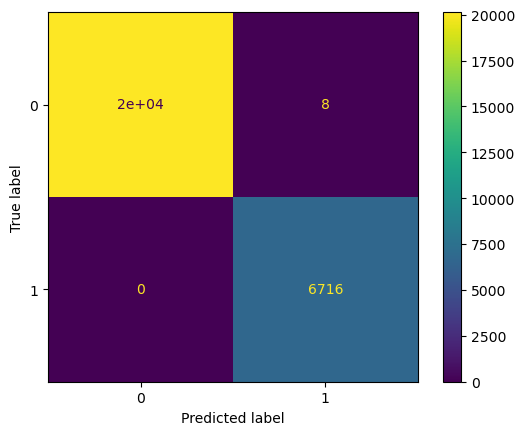

In [41]:
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();


In [42]:
feature_importances = pd.Series(
    best_rf.feature_importances_, index=X_train.columns
).sort_values(ascending=False)

feature_importances.head()


maj_landcover_code_y    0.002087
inspection_id           0.001523
X_948                   0.000787
X_2449                  0.000740
X_343                   0.000737
dtype: float64

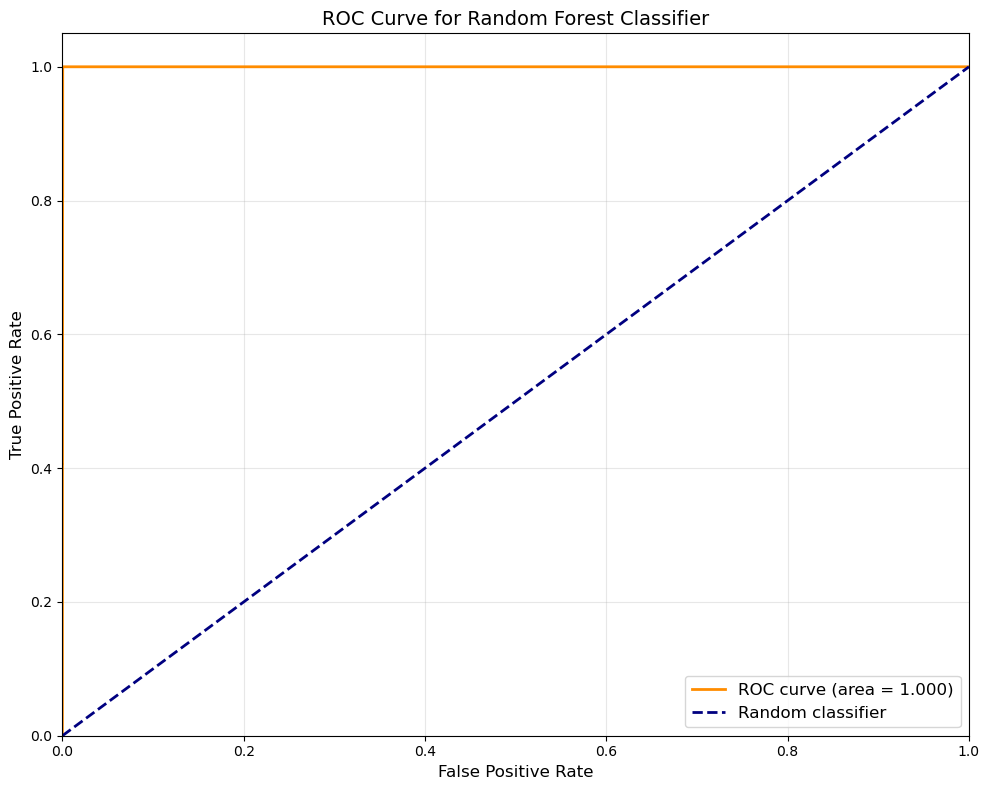

ROC AUC Score: 0.9998


In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Generate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Create the plot
plt.figure(figsize=(10, 8))

# Plot ROC curve
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.3f})")

# Plot baseline
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random classifier")

# Style the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve for Random Forest Classifier", fontsize=14)
plt.legend(loc="lower right", fontsize=12)

# Add grid
plt.grid(alpha=0.3)

# Display the plot
plt.tight_layout()
plt.show()

# Print numeric results for reference
print(f"ROC AUC Score: {roc_auc:.4f}")
